In [1]:
from typing import Any
from pytorch_lightning.utilities.types import STEP_OUTPUT

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy

import pytorch_lightning as pl
import h5py as h5
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

In [2]:
class EmbeddingDataset(Dataset):
    def __init__(self, root) -> None:
        self.data = h5.File(root, "r")

        self.embeddings = self.data["embeddings"]
        self.labels = self.data["labels"]
        self.domains = self.data["domains"]

    def __len__(self) -> int:
        return len(self.embeddings)

    def __getitem__(self, index) -> Any:
        return self.embeddings[index], self.labels[index], self.domains[index]
    
dataset = EmbeddingDataset("../data/Scratch-1700591575.7427056-all-embeddings.h5")

(array([ 59436.,      0.,  34904.,      0.,      0.,  85054.,      0.,
        129838.,      0., 146722.]),
 array([0.        , 0.40000001, 0.80000001, 1.20000005, 1.60000002,
        2.        , 2.4000001 , 2.79999995, 3.20000005, 3.5999999 ,
        4.        ]),
 <BarContainer object of 10 artists>)

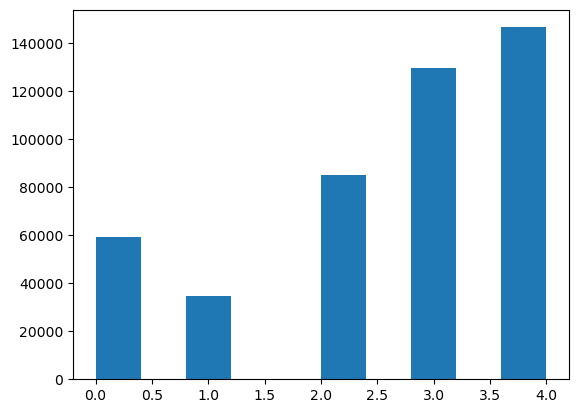

In [3]:
plt.hist(dataset.domains)

In [4]:
indices_pd = {}
for i in range(len(dataset)):
    if int(dataset.domains[i]) in indices_pd:
        indices_pd[int(dataset.domains[i])].append(i)
    else:
        indices_pd[int((dataset.domains[i]))] = [i]

In [5]:
indices_ss = {k: np.random.choice(v, 20_000, replace=False) for k, v in indices_pd.items()}

In [6]:
all_indices = torch.cat([torch.from_numpy(v) for _,v in indices_ss.items()], dim=0)

In [7]:
len(all_indices)

100000

In [8]:
dataset_ss = Subset(dataset, all_indices)

In [9]:
num_samples = len(dataset_ss)
train_samples = int(num_samples*0.8)
val_samples = num_samples - train_samples
train_set, val_set = random_split(dataset_ss, [train_samples, val_samples])

In [10]:
train_loader = DataLoader(train_set, 64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, 128, shuffle=False, num_workers=2)

In [22]:
from typing import Any, Optional


from pytorch_lightning.utilities.types import STEP_OUTPUT


class EmbeddingModule(pl.LightningModule):
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Linear(
            in_features=2048,
            out_features=5,
        )
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=5, average='none')

        self.correct = torch.zeros(5)
        self.total = torch.zeros(5)
        self.val_no = 0

    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        X, t, d = batch

        y = self.model(X)
        loss = self.criterion(y, d.to(torch.long))

        self.log("loss", loss)

        return loss
    
    def on_validation_start(self) -> None:
        self.correct = torch.zeros(5)
        self.total = torch.zeros(5)
    
    def validation_step(self, batch, batch_idx) -> STEP_OUTPUT | None:
        X, t, d = batch

        y = self.model(X)
        pred = y.argmax(dim=1)

        for i in range(len(d)):
            self.total[int(d[i])] += 1
            if d[i] == pred[i]:
                self.correct[int(d[i])] += 1

    def on_validation_end(self) -> None:
        acc_per_class = self.correct / self.total
        accs_dict = {f"Class_{i}": acc for i, acc in enumerate(acc_per_class)}

        # self.log_dict(accs_dict)
        logger: SummaryWriter = self.logger.experiment
        
        for k in accs_dict:
            logger.add_scalar(k, accs_dict[k], self.val_no)

        self.val_no += 1

    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-2)

        return optimizer

In [23]:
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=100,
    val_check_interval=1250//2
)
trainer.fit(
    model=EmbeddingModule(),
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | Linear             | 10.2 K
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/yasin/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/yasin/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/yasin/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [1]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 125148), started 0:00:41 ago. (Use '!kill 125148' to kill it.)